In [6]:
# Dependencies
!pip install --upgrade pip
!pip install typing-extensions
!pip install boto3
!pip install amazon-braket-sdk --upgrade --upgrade-strategy eager
!pip install --upgrade amazon-braket-sdk
!pip install --upgrade amazon-braket-schemas

In [1]:
# General imports
import numpy as np
import math
import matplotlib.pyplot as plt

# AWS imports: Import Braket SDK modules
from braket.aws import AwsDevice
from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator

In [2]:
# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
# set up device: Local Simulator
device = LocalSimulator()

In [4]:
@circuit.subroutine(register=True)
def qft(qubits):    
    """
    Construct a circuit object corresponding to the Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.
    
    Args:
        qubits (int): The list of qubits on which to apply the QFT
    """
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    for k in range(num_qubits):
        # First add a Hadamard gate
        qftcirc.h(qubits[k])
    
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # Start on the qubit after qubit k, and iterate until the end.  When num_qubits==1, this loop does not run.
        for j in range(1, num_qubits - k):
            angle = 2*math.pi/(2**(j+1))
            qftcirc.cphaseshift(qubits[k+j], qubits[k], angle)
            
    # Then add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(num_qubits/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
        
    return qftcirc

In [5]:
# show inverse QFT example circuit
num_qubits = 4
qubits=range(num_qubits)
qft_circ = qft(qubits)
print('QFT CIRCUIT:')
print(qft_circ)


QFT CIRCUIT:
T  : |0|     1     |      2      |           3           |      4      |     5     | 6  | 7  |
                                                                                              
q0 : -H-PHASE(1.57)-PHASE(0.79)---PHASE(0.39)--------------------------------------------SWAP-
        |           |             |                                                      |    
q1 : ---C-----------|-----------H-|-----------PHASE(1.57)-PHASE(0.79)---------------SWAP-|----
                    |             |           |           |                         |    |    
q2 : ---------------C-------------|-----------C-----------|-----------H-PHASE(1.57)-SWAP-|----
                                  |                       |             |                |    
q3 : -----------------------------C-----------------------C-------------C-----------H----SWAP-

T  : |0|     1     |      2      |           3           |      4      |     5     | 6  | 7  |


In [9]:
def create_binary_vector(num, num_qbits):
    return list(map(int, list(bin(num).lstrip("0b").zfill(num_qbits))))

GateModelQuantumTaskResult(task_metadata=TaskMetadata(braketSchemaHeader=BraketSchemaHeader(name='braket.task_result.task_metadata', version='1'), id='589e13cb-f76e-4b2c-a615-10a40ce48183', shots=0, deviceId='braket_sv', deviceParameters=None, createdAt=None, endedAt=None, status=None, failureReason=None), additional_metadata=AdditionalMetadata(action=Program(braketSchemaHeader=BraketSchemaHeader(name='braket.ir.openqasm.program', version='1'), source='OPENQASM 3.0;\nqubit[4] q;\nh q[0];\ncphaseshift(1.5707963267948966) q[1], q[0];\ncphaseshift(0.7853981633974483) q[2], q[0];\ncphaseshift(0.39269908169872414) q[3], q[0];\nh q[1];\ncphaseshift(1.5707963267948966) q[2], q[1];\ncphaseshift(0.7853981633974483) q[3], q[1];\nh q[2];\ncphaseshift(1.5707963267948966) q[3], q[2];\nh q[3];\nswap q[0], q[3];\nswap q[1], q[2];\n#pragma braket result state_vector\n#pragma braket result probability all', inputs={}), dwaveMetadata=None, rigettiMetadata=None, oqcMetadata=None, xanaduMetadata=None, que

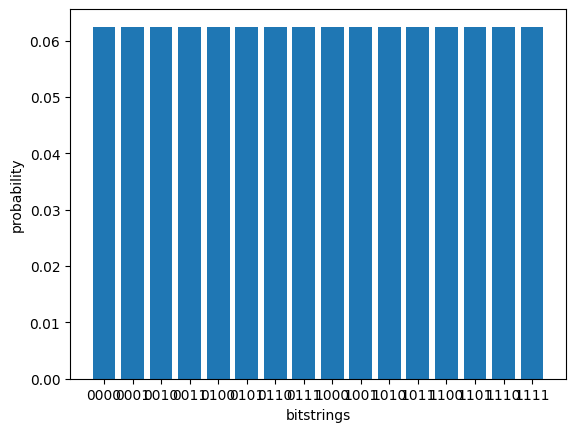

In [13]:
# check output for input |0,0,0> -> expect uniform distribution
num_qubits = 4
qubits=range(num_qubits)
my_qft_circ = qft(qubits)

# specify desired results_types
my_qft_circ.state_vector()
my_qft_circ.probability()

# Run the QFT on 3 qubits with all zeros input
task = device.run(my_qft_circ, shots=0)
result = task.result()
print(result)
state_vector = result.values[0]
probs_values = result.values[1]

# format statevector for output
state_vec_pretty = np.round(state_vector, decimals=3)
state_vec_pretty = [ampl if np.abs(ampl)>10**(-5) else 0 for ampl in state_vec_pretty]

# bitstrings
format_bitstring = '{0:0' + str(num_qubits) + 'b}'
bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

# Print the output state vector
print('Exact statevector:\n', state_vec_pretty)

# plot probabalities
plt.bar(bitstring_keys, probs_values);
plt.xlabel('bitstrings');
plt.ylabel('probability');